Pytorch Tutorial here: https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [234]:
!pip3 install gymnasium[classic_control]

Sample function: 0.86\sin(4.5\log(x+2))+0.5

Operations:

1. [subtract] [x]
2. [add] [x]
3. [multiply] [x]
4. [divide] [x]
5. [arcsin]
6. [exp]
7. [pow] [x]

In [235]:
import time

In [236]:
from enum import Enum, auto
import math
import numpy as np

lowkey in retrospect I think there should be two types -- sub/add/mul/div vs arcsin/exp/pow/sin/log/none because the latter don't compound. It's just not as well defined.

In [237]:
class Function_Type(Enum):
    SUBTRACT = auto() #- x <- want this to sort of be an input variable correlated with either a or b
    ADD = auto() # + x
    MULTIPLY = auto() # * x
    DIVIDE = auto() # / x
    ARCSIN = auto()
    EXP = auto()
    POW = auto()
    SIN = auto()
    LOG = auto()
    NONE = auto()

    @property
    def inverse(self):
        if self is Function_Type.SUBTRACT:
            return Function_Type.ADD
        elif self is Function_Type.ADD:
            return Function_Type.SUBTRACT
        elif self is Function_Type.MULTIPLY:
            return Function_Type.DIVIDE
        elif self is Function_Type.DIVIDE:
            return Function_Type.MULTIPLY
        elif self is Function_Type.ARCSIN:
            return Function_Type.SIN
        elif self is Function_Type.SIN:
            return Function_Type.ARCSIN
        elif self is Function_Type.LOG:
            return Function_Type.EXP
        elif self is Function_Type.EXP:
            return Function_Type.LOG
        elif self is Function_Type.POW:
            return Function_Type.POW
        elif self is Function_Type.NONE:
            return Function_Type.NONE #in case of just x
        else:
            raise ValueError("Invalid Function :(")

    def operation(self, arg=None):
      #None of these five should be touched
      if self == Function_Type.ADD:
        return lambda x: x + arg
      elif self == Function_Type.SUBTRACT:
        return lambda x: x - arg
      elif self == Function_Type.MULTIPLY:
        return lambda x: x * arg
      elif self == Function_Type.DIVIDE:
        if arg and arg != 0:
          return lambda x: x/arg
        else:
          return lambda x: x
      #here we go
      elif self == Function_Type.NONE:
        return lambda x: x
      elif self == Function_Type.ARCSIN:
        return math.asin
      elif self == Function_Type.EXP:
        return math.exp
      elif self == Function_Type.POW:
        if arg:
          exponent = arg
        else:
          exponent = 2
        return lambda x: math.pow(x, exponent)
      elif self == Function_Type.SIN:
        return math.sin
      elif self == Function_Type.LOG:
        base = arg if arg is not None else math.e
        return lambda x: math.log(x, base)
      else:
        raise ValueError("Invalid Function Type.")

In [326]:
class func():
    #a f( g(x) ) + b
    # x is another func type
    # baseline func is x
    def __init__(self, func_type: Function_Type, a: int, b: int, sub_func = None, complexity: int = 0, arg: float = None):
      self.a = a
      self.b = b
      self.func = func_type
      self.sub_func = sub_func
      self.arg = arg
      if sub_func:
        self.complexity = sub_func.complexity + 1
      else:
        self.complexity = complexity

    def set_complexity(self, x: int):
      self._complexity = x

    def apply_function(self, func_applied: Function_Type, arg: float = None):

      self.a = float(self.a)
      self.b = float(self.b)
      if (self.b == 'nan'):
        self.b = 0

      if func_applied == Function_Type.SUBTRACT:
        self.b -= arg
      elif func_applied == Function_Type.ADD:
        self.b += arg
      elif func_applied == Function_Type.MULTIPLY:
        self.a *= arg
        self.b *= arg
      elif func_applied == Function_Type.DIVIDE:
        self.a /= arg
        self.b /= arg
      elif func_applied == self.func.inverse:
        if (0.9 < self.a < 1.1 and -0.1 < self.b < 0.1):
          return self.sub_func
        else:
          new_func = func(func_applied, 1, 0, sub_func = self, arg = arg) #this should be based on the input arguments
          return new_func #this function should point to the current function (implying we've added another layer to the function)

      else:
          new_func = func(func_applied, 1, 0, sub_func = self, arg = arg)
          return new_func

      return self

    def evaluate(self, x):
      if self.sub_func:
        inner_val = self.sub_func.evaluate(x)
      else:
        inner_val = x  # base variable

      try:
        op = self.func.operation(self.arg)
        val = self.a * op(inner_val) + self.b
      except ValueError:
        val = float('nan')

      if isinstance(val, (np.ndarray, list)):
        val = float(np.mean(val))

      return float(val)

    def __repr__(self):
      return f"{self.a} * {self.func.name}( {self.sub_func} ) + {self.b}"

In [327]:
def generate_samples(n=500, xmin=-10, xmax=10):
    """Generate n evenly spaced samples between xmin and xmax."""
    return np.linspace(xmin, xmax, n)

In [328]:
# Create a simple nested function: f(x) = 2 * SIN(3x + 1) - 4
inner = func(Function_Type.NONE, 3, 1, complexity=1)  # 3x + 1
outer = func(Function_Type.SIN, 2, -4, inner)
print(outer.complexity)
xs = generate_samples()
print(outer)
y = []
for x in xs:
  y.append(outer.evaluate(x))
print(xs[:5], y[:5])

2
2 * SIN( 3 * NONE( None ) + 1 ) + -4
[-10.          -9.95991984  -9.91983968  -9.87975952  -9.83967936] [-2.6727322315740647, -2.8617757763376432, -3.0672556917480924, -3.286204773295143, -3.515461316823936]


In [329]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [347]:
my_func = func(Function_Type.NONE, 1, 10, None, 1) #y = x + 10
#my_func = func(Function_Type.LOG, 4.5, 0, my_func)#y = 4.5 log (x + 10)
#my_func = func(Function_Type.SIN, 0.86, 0.5, my_func)#y = 0.86 sin(4.5 log (x + 10)) + 0.5

In [348]:
print(my_func)

1 * NONE( None ) + 10


In [349]:
print(my_func.complexity)

1


In [350]:
y_my_func = []
for x in xs:
  y_my_func.append(my_func.evaluate(x))
print(xs[:5])
print(y_my_func[:250])

[-10.          -9.95991984  -9.91983968  -9.87975952  -9.83967936]
[0.0, 0.04008016032064177, 0.08016032064128176, 0.12024048096192352, 0.1603206412825653, 0.20040080160320706, 0.24048096192384705, 0.2805611222444888, 0.3206412825651306, 0.36072144288577235, 0.40080160320641234, 0.4408817635270541, 0.48096192384769587, 0.5210420841683359, 0.5611222444889776, 0.6012024048096194, 0.6412825651302612, 0.6813627254509012, 0.7214428857715429, 0.7615230460921847, 0.8016032064128247, 0.8416833667334664, 0.8817635270541082, 0.92184368737475, 0.96192384769539, 1.0020040080160317, 1.0420841683366735, 1.0821643286573153, 1.1222444889779553, 1.162324649298597, 1.2024048096192388, 1.2424849699398806, 1.2825651302605205, 1.3226452905811623, 1.362725450901804, 1.402805611222444, 1.4428857715430858, 1.4829659318637276, 1.5230460921843694, 1.5631262525050094, 1.6032064128256511, 1.643286573146293, 1.6833667334669329, 1.7234468937875747, 1.7635270541082164, 1.8036072144288582, 1.8436873747494982, 1.88376

In [351]:
from gymnasium import spaces
import copy

class FunctionSimplifyEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, initial_func: func, max_complexity=10, n_samples=500):
        super().__init__()

        #First action space: set of possible functions that could be applied
        self.action_space = spaces.Dict({
                                "func": spaces.Discrete(len(Function_Type)),           # which function
                                "arg": spaces.Box(low=-10.0, high=10.0, shape=(1,), dtype=np.float32)  # coeff
                            })

        #list of n samples of data points (what can be observed from the function)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(n_samples, 2), dtype=np.float32
        )

        self.initial_func = initial_func
        self.max_complexity = max_complexity
        self.current_func = None
        self.history = []
        self.x_samples = generate_samples(n_samples)

    def _get_obs(self):
        y_samples = []
        for x in self.x_samples:
            try:
                val = self.current_func.evaluate(x)
                if np.isnan(val) or np.isinf(val):
                    val = 0.0
            except Exception:
                val = 0.0
            y_samples.append(float(val))

        y_samples = np.array(y_samples, dtype=np.float32)
        # print(len(self.x_samples), len(y_samples))
        return np.stack([self.x_samples, y_samples], axis=-1)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_func = copy.deepcopy(self.initial_func)
        self.history = []
        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        func_action, arg = action
        func_action = list(Function_Type)[func_action]
        self.history.append((func_action, arg))
        prev_complexity = self.current_func.complexity
        prev_b = self.current_func.b
        prev_a = self.current_func.a

        try:
            new_func = self.current_func.apply_function(func_action, arg)
        except Exception as e:
            reward = -1.0
            obs = self._get_obs()
            return obs, reward, True, False, {"error": str(e)}
        current_complexity = new_func.complexity

        # reward = reduction in complexity
        reward = float(prev_complexity - current_complexity)
        if abs(new_func.b) >= abs(prev_b):
          reward -= 0.1
        if abs(new_func.a - 1) >= abs(prev_a):
          reward -= 0.1

        if prev_complexity > current_complexity:
          print(f"OMG! {prev_complexity} {current_complexity} {self.current_func}")

        # termination logic
        done = current_complexity <= 0 or current_complexity > self.max_complexity

        self.current_func = new_func
        obs = self._get_obs()
        info = {
            "func": repr(self.current_func),
            "history": [(f.name, arg) for f, arg in self.history],
            "complexity": current_complexity,
        }

        return obs, reward, done, False, info

    def render(self):
        print(f"Function: {self.current_func}")
        print(f"Complexity: {self.current_func.complexity}")
        print(f"History: {self.history}")

    def close(self):
        pass

In [352]:
my_func

1 * NONE( None ) + 10

In [353]:
env = FunctionSimplifyEnv(initial_func=my_func)
obs, _ = env.reset()

In [354]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

yoink

In [355]:
import math
import random
import time
from itertools import count
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from IPython import display


In [356]:
class HybridDQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        self.q_head = nn.Linear(128, n_actions)
        self.arg_head = nn.Linear(128, n_actions)  # continuous value per action

    def forward(self, x):
        x = x.view(x.size(0), -1)
        feats = self.shared(x)
        q_values = self.q_head(feats)
        arg_values = self.arg_head(feats) * 5.0
        return q_values, arg_values

In [357]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [358]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [359]:
episode_durations = []
is_ipython = "inline" in plt.get_backend()

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [360]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [361]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4
NUM_EPISODES = 200

In [362]:
env = FunctionSimplifyEnv(initial_func=my_func, max_complexity=10)
obs, _ = env.reset()

In [ ]:
n_actions = len(Function_Type)
# state, info = env.reset()
# state = state.flatten()
n_observations = obs.flatten().shape[0]

policy_net = HybridDQN(n_observations, n_actions).to(device)
target_net = HybridDQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

# ============================================================
# --- Action Selection ---
# ============================================================
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            q_values, arg_values = policy_net(state)
            action_idx = q_values.max(1).indices.item()
            arg = arg_values[0, action_idx].item()
    else:
        action_idx = random.randint(0, n_actions - 1)
        arg = random.uniform(-5, 5)

    return action_idx, arg


# ============================================================
# --- Optimization Step ---
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s,a)
    q_values, _ = policy_net(state_batch)
    state_action_values = q_values.gather(1, action_batch)

    # Compute target Q values
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_q_values, _ = target_net(non_final_next_states)
    next_state_values[non_final_mask] = next_q_values.max(1).values.detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Loss + backprop
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

def soft_update():
    for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)

# ============================================================
# --- Training Loop ---
# ============================================================
print("Training begun!\n")
episode_durations = []

for i_episode in range(1, NUM_EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        # --- Select & apply action ---
        action_idx, arg_value = select_action(state)
        action_tuple = (action_idx, np.array([arg_value], dtype=np.float32))

        observation, reward, done, truncated, info = env.step(action_tuple)
        reward = torch.tensor([reward], device=device)

        # print(f"\nEpisode {i_episode} | Step {t}")
        # print(f"  Action: {list(Function_Type)[action_idx].name} (arg={arg_value:.3f})")
        # print(f"  Reward: {reward.item():.3f}")
        # print(f"  Complexity: {env.current_func.complexity}")
        # print(f"  Function: {env.current_func}")

        if (env.current_func.complexity < 2):
          print("MY GOSH!!!!!!! ")
          print(f"\nEpisode {i_episode} | Step {t}")
          print(f"  Action: {list(Function_Type)[action_idx].name} (arg={arg_value:.3f})")
          print(f"  Reward: {reward.item():.3f}")
          print(f"  Complexity: {env.current_func.complexity}")
          print(f"  Function: {env.current_func}")

        # --- Prepare next state ---
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)

        # --- Store transition ---
        memory.push(state, torch.tensor([[action_idx]], device=device), next_state, reward)
        state = next_state

        # --- Train ---
        optimize_model()
        soft_update()

        if done:
            episode_durations.append(t + 1)
            print(f"Episode {i_episode} finished after {t + 1} steps\n")
            break

print("Training complete!")
plt.figure()
plt.plot(episode_durations)
plt.title("Episode Durations (steps until done)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()


In [280]:
with open("sample_output.txt", "r") as f:
    log_text = f.read()

FileNotFoundError: [Errno 2] No such file or directory: 'sample_output.txt'

In [98]:
import re
import matplotlib.pyplot as plt


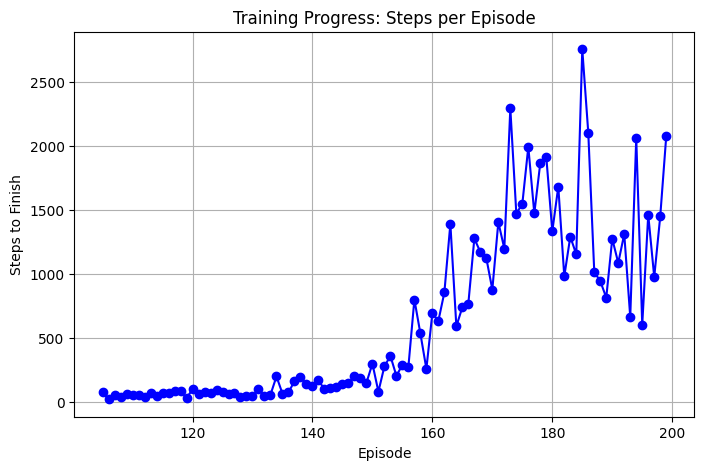

In [99]:
episodes = []
steps = []

for match in re.finditer(r"Episode\s+(\d+)\s+finished\s+after\s+(\d+)\s+steps", log_text):
    ep = int(match.group(1))
    st = int(match.group(2))
    episodes.append(ep)
    steps.append(st)

# Plot
plt.figure(figsize=(8,5))
plt.plot(episodes, steps, marker='o', linestyle='-', color='blue')
plt.xlabel("Episode")
plt.ylabel("Steps to Finish")
plt.title("Training Progress: Steps per Episode")
plt.grid(True)
plt.show()